# Logistic Regression

## Benj McMullin

## Math 403

## 12/4/2023

In [45]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
import pandas as pd
import statsmodels.api as sm
import time
from matplotlib import pyplot as plt

## Problem 1

Create a classifier called `LogiReg` that accepts an $(n \times 1)$ array $y$ of binary labels ($0$'s and $1$'s) as well as an $(n \times d)$ array $X$ of data points. Write a `fit()` method that finds and saves the optimal $\widehat{\boldsymbol{\beta}}$.

## Problem 2

Write a method called `predict_prob()` that accepts an $(n \times d)$ array $x\_test$ and returns $P(Y=1 | x\_test)$. Also write a method called `predict()` that calls `predict_prob()` and returns an array of predicted labels ($0$'s or $1$'s) for the given array $x\_test$.

In [46]:
class LogiReg(): 

    def fit(self, X, y):
        """
        input:
        X: ndarray(n, d)
        y: ndarray(n, 1) taking values only in {0,1}
        
        Save y and X as attributes.
        Updates beta, the coefficient array of shape (d, 1) that
        minimizes the negative log likelihood for the given data 
        with the model p(y|x) = sigm(x^T @ beta).      
        """
        # add column of ones to X
        if len(X.shape) == 1:
            X = X[:, np.newaxis]
        X = np.column_stack((np.ones((X.shape[0])), X))

        # save X and y as attributes
        self.X = X
        self.y = y

        # define negative log likelihood function
        sum = lambda B: np.sum([y[i] * np.log(1 + np.exp(-X[i] @ B)) + (1 - y[i]) * np.log(1 + np.exp(X[i] @ B)) for i in range(X.shape[0])])

        # minimize negative log likelihood function
        self.beta = minimize(sum, np.ones(X.shape[1])).x

        
    def predict_prob(self, x_test, add_col=True):
        """
        Returns the predicted probability of an input x_test.
        If x_test has shape (p, q), then the predicted probability
        has shape (1, q).
        """ 
        # add column of ones to x_test
        if add_col:
            x_test = np.column_stack((np.ones(len(x_test)), x_test))
        
        # return predicted probability
        with np.errstate(over = 'ignore'):
            return 1  /(1 + np.exp(-x_test @ self.beta))
        
        
    def predict(self, x_test, add_col=True):
        """
        Returns the predicted classification (1 or 0) of x_test.
        If x_test has shape (p, q), then the predicted classification
        has shape (1, q).
        """      
        return np.where(self.predict_prob(x_test, add_col) > 0.5, 1, 0)

## Problem 3

Test your classifier from the previous two problems using arrays $X$, $y$, and $X\_test$. Train your classifier on $X$ and $y$. Then generate a list of predicted labels using your trained classifier and $X\_test$, and use it to plot $X\_test$ with a different color for each predicted label.

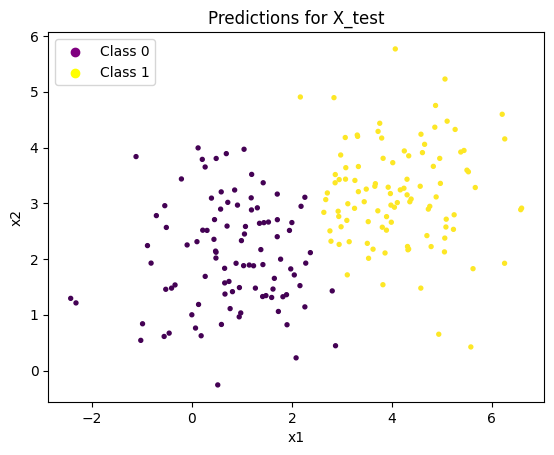

In [47]:
data = np.column_stack(( 
    np.concatenate(( 
        # draw from 2 2-dim. multivariate normal dists.
        np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
        np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) )), 
    # labels corresonding to each distribution
    np.concatenate(( np.zeros(100), np.ones(100) )) ))
np.random.shuffle(data)
# extract X and y from the shuffled data
X = data[:,:2]
y = data[:,2].astype(int)

X_test = np.concatenate(( 
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) ))
np.random.shuffle(X_test)


# Pull out the y and X from the data
X = data[:,:2]
y = data[:,2].astype(int)

X_test = np.concatenate(( 
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) ))
np.random.shuffle(X_test)


# Fit the model
model = LogiReg()
model.fit(X, y)

predictions = model.predict(X_test)

# Plot the predictions
plt.scatter(X_test[:,0], X_test[:,1], s=8, c=predictions,)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Predictions for X_test")
# Create the legend
plt.legend(handles=[plt.scatter([],[],color='purple'), plt.scatter([],[],color='yellow')], labels=['Class 0', 'Class 1'])
plt.show()

## Problem 4

Using each of `LogiReg`, `statsmodels.Logit`, `sklearn.LogisticRegression`, and `sklearn.svm` train a logistic regression classifier on $X$ and $y$ to generate a list of predicted labels for $X\_test$. Then, using $y\_test$, print the accuracy scores for each trained model. Compare the accuracies and training/testing time for all three classifiers. Be sure to add a constant feature with each model.

In [48]:
# predefine the true beta
beta = np.random.normal(0, 7, 20)

# X is generated from 2 20-dim. multivariate normal dists.
X = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100) ))
np.random.shuffle(X)
# create y based on the true beta
pred = 1. / (1. + np.exp(-X @ beta))  
y = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

# X_test and y_test are generated similar to X and y
X_test = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100) ))
np.random.shuffle(X_test)
pred = 1. / (1. + np.exp(-X_test @ beta))
y_test = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )



X_logit = sm.add_constant(X)
X_test_logit = sm.add_constant(X_test)

# Use the LogiReg class to fit the model
start = time.perf_counter()
logireg = LogiReg()
logireg.fit(X, y)
time_logireg = np.round(time.perf_counter() - start, 5)

probs = logireg.predict(X_test)
preds = np.where(probs > 0.5, 1, 0)
acc_logireg = accuracy_score(y_test, preds)

# Use statsmodels to fit the model
start = time.perf_counter()
logit = sm.Logit(y, X_logit).fit_regularized(disp=0)
time_logit = np.round(time.perf_counter() - start, 5)

probs = logit.predict(X_test_logit)
preds = np.where(probs > 0.5, 1, 0)
acc_logit = accuracy_score(y_test, preds)

# Use sklearn to fit the model
start = time.perf_counter()
sklearn = LogisticRegression(fit_intercept = True).fit(X, y)
time_sklearn = np.round(time.perf_counter() - start, 5)

labels = sklearn.predict(X_test)
acc_sklearn = accuracy_score(y_test, labels)

# Use sklearn to fit the model
start = time.perf_counter()
svm = svm.SVC(kernel = 'linear').fit(X, y)
time_svm = np.round(time.perf_counter() - start, 5)

labels = svm.predict(X_test)
acc_svm = accuracy_score(y_test, labels)

# Print the results
print('Logireg: \t', time_logireg, "seconds,\t Score = ", acc_logireg)
print('Logit: \t\t', time_logit, "seconds,\t Score = ", acc_logit)
print('Sklearn: \t', time_sklearn, "seconds,\t Score = ", acc_sklearn)
print('SVM: \t\t', time_svm, "seconds,\t Score = ", acc_svm)

Logireg: 	 3.30795 seconds,	 Score =  0.94
Logit: 		 0.02578 seconds,	 Score =  0.96
Sklearn: 	 0.00655 seconds,	 Score =  0.95
SVM: 		 0.00452 seconds,	 Score =  0.955


c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


## Problem 5

Import the Iris Dataset and perform a train-test split on only the first two columns of the data with `test_size=0.4`. Train a multinomial logistic regression model using the training data with an added constant feature, and generate prediction labels for the test data.

Plot the test data by color using your prediction labels. Also, print the model score

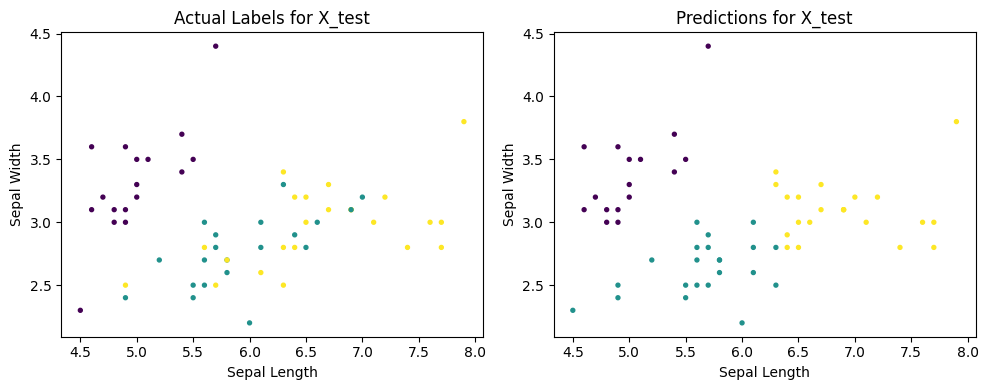

In [49]:
# Load the iris data
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# fit model
model = LogisticRegression(multi_class = 'multinomial', fit_intercept = True).fit(X_train, y_train)

# predict labels
labels = model.predict(X_test)

# calculate accuracy
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], s = 8, c = y_test)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title("Actual Labels for X_test")

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], s = 8, c = labels)
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Predictions for X_test")

plt.tight_layout()
plt.show()